# **Bring Your Art to Life with CycleGANs**
I hate to admit it, but I suck at art.

As a self-proclaimed artist, I’ve always dreamed of creating beautiful, breathtaking works of art. But sadly, stick figures and smiley faces seem to be the best that I can do.

After so many years, I refuse to let my lack of artistic ability hold me back. That’s why I decided to take matters into my own hands and create a GAN (generative adversarial network) to turn my nasty sketches into beautiful photographs. Using a combination of machine learning algorithms and a dataset of high-quality photographs, I built a GAN to transform my scribbles into realistic images that even Monet would be proud of.

In this notebook we will **implement the CycleGAN** to convert sketches into photographs to prove GANs can greatly improve the current creative design process. Whether you are an amateur like me who is looking to improve their art, or a seasoned professional that wants to save time, expiriment quick and increase efficiency, this build can help everyone.

You can find the original paper [here](https://arxiv.org/pdf/1703.10593.pdf), and an amazing CycleGAN implementation that this code is based off of [here](https://www.youtube.com/watch?v=wHo4N3njxDY). 

In [1]:
# Importing libraries and packages 
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

import glob
import random
from torch.utils.data import Dataset
from PIL import Image

**Formatting Data**

I've chosen to work with the [CUHK Face Sketch Database (CUFS)](https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs), and the [Pretty Face
Images](https://www.kaggle.com/datasets/yewtsing/pretty-face) datasets. CUHK has well drawn professional sketches whereas the Pretty Face sketches are rough. Using both datasets will help the model generalize better. Both datasets had different file structures, so I began by manipulating the data and storing train and test files for both the A and B domain images. The A domain is sketch images, and the B domain is photograph images. Train and test data is split approximatley 80-20.

In [2]:
# Defining CUHK Face Sketch Database files 
# They are already split into train and test folders
train_A1_paths = glob.glob('../input/face-sketch-database/dataset/trainA/*.jpg')
train_B1_paths = glob.glob('../input/face-sketch-database/dataset/trainB/*.jpg')
print("For CUHK Face Sketch Database:")
print('Number of trainA：',len(train_A1_paths))
print('Number of trainB：',len(train_B1_paths))

test_A1_paths = glob.glob('../input/face-sketch-database/dataset/testA/*.jpg')
test_B1_paths = glob.glob('../input/face-sketch-database/dataset/testB/*.jpg')
print('Number of testA：',len(test_A1_paths))
print('Number of testB：',len(test_B1_paths))

# For Pretty Face Dataset sort and order face and sketch folders
# Sorted so that paired files are located at the same index 
prettyFaceSketches = sorted(os.listdir("/kaggle/input/pretty-face/sketch/sketch"))
prettyFaceImages = sorted(os.listdir("/kaggle/input/pretty-face/face/face"))
print("\nFor Pretty Face Dataset:" )
print("Number of photographs: ", len(prettyFaceImages), "\nNumber of sketches:", len(prettyFaceSketches))

# Train and test split 
# Got the number of train files wanted (80%) and randomly generated numbers within length of total files
numOfTrain = math.floor(len(prettyFaceSketches)* 0.8)
trainIndices = random.sample(range(len(prettyFaceSketches)), numOfTrain)
print("\nSome train indices: ", trainIndices[:5],"\nNumber of train indices:", len(trainIndices))

# All leftover files will be used for testing 
testIndices = [i for i in range(len(prettyFaceSketches)) if i not in trainIndices]
print("Some test indices: ", testIndices[:5],"\nNumber of test indices:", len(testIndices))

# Defining sketch and photo train and test lists 
train_A2_paths, train_B2_paths, test_A2_paths, test_B2_paths = [], [], [], []

# Formatting files and adding files at specified indices to respective lists 
for i in trainIndices:
    train_A2_paths.append("../input/pretty-face/sketch/sketch/" + (list(prettyFaceSketches)[i]))
    train_B2_paths.append("../input/pretty-face/face/face/" +(list(prettyFaceImages)[i]))
                          
for i in testIndices:
    test_A2_paths.append("../input/pretty-face/sketch/sketch/" +(list(prettyFaceSketches)[i]))
    test_B2_paths.append("../input/pretty-face/face/face/" +(list(prettyFaceImages)[i]))


print('\nNumber of train sketches: ', len(train_A2_paths),'\nNumber of train photos: ', len(train_B2_paths), 
      '\nNumber of test sketches: ', len(test_A2_paths),'\nNumber of test photos: ', len(test_B2_paths))

# Concat train and test folders for the 2 dataset
train_A = train_A1_paths + train_A2_paths
train_B = train_B1_paths + train_B2_paths
test_A = test_A1_paths + test_A2_paths
test_B = test_B1_paths + test_B2_paths
print('\nTotal number of train sketches: ', len(train_A))

For CUHK Face Sketch Database:
Number of trainA： 160
Number of trainB： 160
Number of testA： 28
Number of testB： 28

For Pretty Face Dataset:
Number of photographs:  3318 
Number of sketches: 3318

Some train indices:  [2083, 1620, 963, 1458, 351] 
Number of train indices: 2654
Some test indices:  [3, 6, 10, 11, 13] 
Number of test indices: 664

Number of train sketches:  2654 
Number of train photos:  2654 
Number of test sketches:  664 
Number of test photos:  664

Total number of train sketches:  2814


**Hyperparameters**

Next, I defined our hyperparameters and stored them in an object for better code organization and reusability. On initialization, the Hyperparameters class takes an arbitrary number of keyword arguments and stores them as dictionary attributes. All hyperparameter values are taken as recorded in the [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf) paper.

In [3]:
# Initializing hyperparameters 

class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(
    epoch=0,
    n_epochs=60,    
    dataset_train_mode="train",
    dataset_test_mode="test", 
    batch_size=4,        
    lr=.0002,
    decay_start_epoch=59,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    n_critic=5,
    sample_interval=100,
    num_residual_blocks=19,
    lambda_cyc=10.0,
    lambda_id=5.0)


**Utility Functions**

Some images scrapped for the datasets may not be in RGB format. I've defined the **convert_to_rgb** function to return new RGB images using the pillow library. 

I created the **ImageDataset** class to return train and test files for our dataloader. In the __init__ method, train or test files are respectly selected, and the __getitem__ method is called when grabbing a batch of images. Files are first opened as Pillow Images, a corresponding B domain image is selected if one exists, and images are converted to the correct format and applied transformations before being returned.

In [4]:
# Defining utility functions 

def convert_to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ImageDataset(Dataset):
    def __init__(self, transforms_=None, unaligned=False, mode="train", train_A=train_A, train_B=train_B, test_A=test_A, test_B=test_B):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned        

        if mode == "train":
            self.files_A = train_A
            self.files_B = train_B
        else: 
            self.files_A = test_A
            self.files_B = test_B

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        # a % b => a is divided by b, and the remainder of that division is returned.

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = convert_to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = convert_to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
  
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

**Visualization Methods**

Some more functions and methods are defined below to be leveraged during training in order to view progress outputs 
1. **show_img**: Given an image and size this function first unnormalizes the images (from the transformations that will be applied), coverts torch tensors to NumPy arrays, generates a figure, and transposes dimensions to the correct format required by the Matplotlib library
2. **to_img**: Reshapes an image to the requested size while satisfying requirements set in our hyperparameter object
3. **plot_output**: Reads provided image paths and draws an image with requested dimensions

In [5]:
# Image Visualization Methods

def show_img(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg

def plot_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

**Transformations and Dataloaders**

For the transformation, the images are first simply resized to our specified dimensions using the BICUBIC resampling filter. This is a high-quality resampling filter that produces smooth artifact-free results but is slower. As always the images are converted to a tensor to be manipulated and have differential equations calculated. And the tensors are finally normalized to a regular gaussian distribution with a mean of 0.5 and a standard deviation of 0.5.

Our train and test dataloaders are defined by leveraging the ImageDataset class previously defined.

In [6]:
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

train_dataloader = DataLoader(
    ImageDataset(mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)

val_dataloader = DataLoader(
    ImageDataset(mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


**Lets view some data!**

Finally we can view some sample data from our datasets. I grab a batch of data from the training dataloader and utilize the **make_grid** method from torchvision and our previously defined **show_img** method to compare A and B domain images if they have a corresponding pair, otherwise a random photograph will be displayed. This is one of the greatest benefits of the CycleGAN, you do not need paired data. 

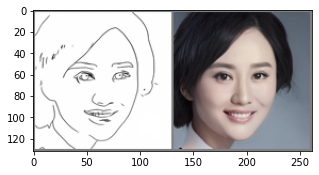

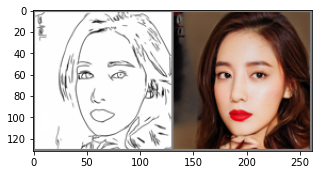

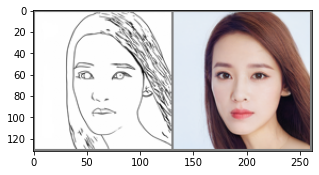

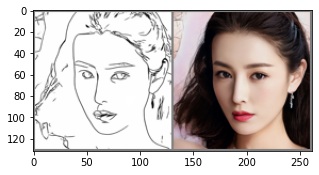

In [7]:
pic_size = 5

dataiter = iter(train_dataloader)
images = dataiter.next()

for i in range(len(images["A"])):
  show_img(make_grid([images["A"][i],images["B"][i]]), size=pic_size)

**Replay Buffer** 

The replay buffer is an important feature leveraged by CycleGANs to **improve training stability and model performance**. Due to the adversarial nature of the model, generated images between batches can vary greatly. The replay buffers **stores** a number of images (50 in our case as described in the paper) and returns a newly or previously generated image with a 50% probability. This allows the model to see a **diverse range of images** rather then just the most recent batch.

The replay buffer first initializes an empty buffer array. When the **push_and_pop** method is called, images are first stored in the buffer if not full, and then appended or popped to the returned array.

In [8]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                # Randomly returns old image with a probability of 0.5 and replaces image in buffer
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[
                        i
                    ] = element  # replaces the older image with the newly generated image.
                else:
                    # send current newly generated image
                    to_return.append(element)
        return Variable(torch.cat(to_return)) 

**Decaying learning rate**

As described in the paper I incrementally decay the learning rate to 0 after reaching 100 epochs of training. This helps our model **avoid oscillations and avoid overshooting.** 

After initializing and setting the object parameters, the step method **returns a smaller and smaller learning rate value** after hitting the decay_start_epoch. 

In [9]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        # Checks if current epoch has passed decay start value. 
        # Will return one if current epoch < decay_start_epoch
        # Otherwise will begin LR decay
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

**Initializing Weights**

Initializing weights is a common practice in DL. It ensures weights and biases have a reasonable standard deviation centred around a normal distribution. **This helps to stabilize a model's performance and converge more quicker.**

I use class properties to ensure convolutional weights have a mean of 0 and a standard deviation of 0.02, while the batch norm weights are initiated to a mean of 1 and a standard deviation of 0.02. All biases are initialized to 0.

In [10]:
def initialize_conv_weights_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

**Residual Blocks**

Another important feature leveraged by CycleGANs is the use of residual blocks. These blocks are **simple models** that extract features but do not change the data size. They **add their outputs to the input** and pass this on to the next sequence of operations. By adding these shortcuts or skip connection to flow information, residual blocks help prevent the vanishing gradient problem that many deeper networks witness that causes degrading performance.

I implement the residual block described in the paper comprising of Reflection Padding, Convolution, Instance Normalization and the ReLU activation.

In [11]:
# Residual block with two convolution layers

class ResidualBlock(nn.Module):
    def __init__(self, in_channel):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Better image quality at edges
            nn.Conv2d(in_channel, in_channel, 3), 
            nn.InstanceNorm2d(in_channel), # Normalizes the activations of a neural network layer for each individual example
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel),
        )

    def forward(self, x):
        return x + self.block(x)

**The Generator**

We have two generators, one that translates images A to B and one that does the reverse, B to A. 
Both utilize the same architecture but learn their own parameters. 

This model begins by downsampling the image by half during feature extraction, next come the residual blocks that do not change image size, and finally the model upsamples the blocks by a factor of 2 with nearest neighbour interpolation. 

In [12]:
# Generator

""" As per Paper -- Generator follows architecture:
c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,
u128, u64,c7s1-3. 
I utilize 19 residual layers to improve accuracy  
 """

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        out_channels = 64

        # Adding first c7s1-64 to model 
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_channels, 7),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        in_channels = out_channels

        # Downsampling from d128 => d256
        for _ in range(2):
            out_channels *= 2
            model += [
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        # Residual Blocks 
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]

        # Upsampling from u128 => u64 with nearest neighbour interpolation 
        for _ in range(2):
            out_channels //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        # Output layer
        model += [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(out_channels, channels, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

**The Discriminator**

Similarly, we will have two discriminators, one evaluating sketches and the other evaluating photographs as real or fake. The CycleGAN uses the **patchGAN** technique which classifies images as real or fake by looking at patches rather than the image overall. This produces high-quality results as the discriminator can focus in on fine details and textures.

The model begins by down-sampling the image by a factor of 16 for the width and height, and then padding is added to maintain the spacial shape during the 4x4 patchGAN.

In [13]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Output shape (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_channels, out_channels, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # Discriminator model of C64 -> C128 -> C256 -> C512
        self.model = nn.Sequential(
            *discriminator_block(channels, out_channels=64, normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=1)
        )
        # Zero padding applied on top and left to maintain spacial shape for the 4×4 kernel

    def forward(self, img):
        return self.model(img)

**Putting everything together**

I create instances of our models with our hyperparameters, ensure everything is on the GPU in order to train faster, initialize weights, and create replay buffers. I also initialize the 3 loss functions we will be using to calculate loss and update our model. 
1. **Adversarial loss**: The adversarial loss is the main loss function used in CycleGANs, and it is used to train the generators and discriminators. The adversarial loss is the MSELoss (mean squared error loss) that measures the difference between the predictions of the discriminators and the target labels (real or fake). The adversarial loss encourages the generators to produce realistic samples that are difficult for the discriminators to distinguish from real samples, and it encourages the discriminators to correctly classify the samples as real or fake.
2. **Reconstruction loss**: The reconstruction loss is used to encourage the generators to preserve the content and style of the input samples. The reconstruction loss measures the difference between the input samples and the generated samples after they have been transformed back to the original domain using the other generator. The reconstruction loss encourages the generators to generate samples that are similar to the input samples, and it helps to prevent the generators from producing samples that are too stylized or distorted.
3. **Identity loss**: The identity loss is used to encourage the generators to preserve the identity of the input samples. The identity loss measures the difference between the input samples and the generated samples after they have been transformed back to the original domain using the same generator. The identity loss encourages the generators to generate samples that are similar to the input samples, and it helps to prevent the generators from changing the identity of the input samples too much.

In [14]:
#  Defining loss, models, and buffer

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

# Loss functions to measure the error between the prediction and the target
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (hp.channels, hp.img_size, hp.img_size)

# Initialize generator and discriminator
Gen_AB = GeneratorResNet(input_shape, hp.num_residual_blocks)
Gen_BA = GeneratorResNet(input_shape, hp.num_residual_blocks)
Disc_A = Discriminator(input_shape)
Disc_B = Discriminator(input_shape)

if cuda:
    Gen_AB = Gen_AB.cuda()
    Gen_BA = Gen_BA.cuda()
    Disc_A = Disc_A.cuda()
    Disc_B = Disc_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

# Initialize weights
Gen_AB.apply(initialize_conv_weights_normal)
Gen_BA.apply(initialize_conv_weights_normal)
Disc_A.apply(initialize_conv_weights_normal)
Disc_B.apply(initialize_conv_weights_normal)

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

Using CUDA


The **save_img_samples** function will be called after each epoch. I generate a batch of images from the validation set, evaluate the models and save the image outputs.

In [15]:
# Sampling and saving images
def save_img_samples(batches_done):
    """Saves a generated sample from the test set"""
    print('batches_done ', batches_done)
    imgs = next(iter(val_dataloader))
    Gen_AB.eval()
    Gen_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = Gen_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = Gen_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=16, normalize=True)
    real_B = make_grid(real_B, nrow=16, normalize=True)
    fake_A = make_grid(fake_A, nrow=16, normalize=True)
    fake_B = make_grid(fake_B, nrow=16, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)    
    path =  '/kaggle/working' + "/%s.png" % (batches_done)   
    save_image(image_grid, path, normalize=False)    
    return path  

**Setting up optimizers and learning rate schedulers**

The optimizers job is to take the gradients of our loss with respect to our models weights and biases in order to nudge parameters in the direction that minimizes loss. Each optimization algorithm has its pros and cons but I decided to use the Adam optimizer as it has adaptive learning rates which will help improve stability. 

b1 and b2 are hyperparameters for the Adam loss function.

- **b1 = first momentum estimate** → helps overcome local minima by adding a fraction of the previous gradient update to the current update
- **b2 = second momentum estimate** → used to implement RMSprop (scales the gradient updates based on the variance)

Adam optimization uses the first and second-moment estimates to compute the gradient updates. Updates are controlled by the combination of momentum and RMSprop terms with the weights controlled by these b1 and b2 hyperparameters.

In [16]:
# Initializing optimizer 

# The generator optimizer chains the Gen_AB and Gen_BA parameters so that they can be
# trained together simutaneously and adhere to the cycle consistency constraint 
optimizer_G = torch.optim.Adam(
    itertools.chain(Gen_AB.parameters(), Gen_BA.parameters()), lr=hp.lr, betas=(hp.b1, hp.b2)
)
optimizer_Disc_A = torch.optim.Adam(Disc_A.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_Disc_B = torch.optim.Adam(Disc_B.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

# Learning rate update schedulers
# Using the torch.optim.lr_scheduler module I connect our custom learning rate scheduler to the optimizers 
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_A, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_B, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

**Training the model**

Now we have all the pieces needed to train our model! I define a **function** that we will run given all of the models, hyperparameters, optimizers, buffers and more that we have created. 

For each epoch I grab a batch of data, convert them into tensors, and define some adversarial ground truths. 
I compute the losses of all the models and run the optimizer on the sum of losses. The optimizer takes a step to update weights and parameters and I log results. **This process is repeated per epoch.**

This is just a highlevel overview of the training process, definately **read the comments below to understand the entire process.**

In [17]:
# Training 

def train(
    Gen_BA,
    Gen_AB,
    Disc_A,
    Disc_B,
    train_dataloader,
    n_epochs,
    criterion_identity,
    criterion_cycle,
    lambda_cyc,
    criterion_GAN,
    optimizer_G,
    fake_A_buffer,
    fake_B_buffer,
    clear_output,
    optimizer_Disc_A,
    optimizer_Disc_B,
    Tensor,
    sample_interval,
    lambda_id,
):
    prev_time = time.time()
    for epoch in range(hp.epoch, n_epochs):
        for i, batch in enumerate(train_dataloader):

            # Set model input
            # Grabbing batches of domain A and B images and converting them to tensor objects 
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))

            # Adversarial ground truths
            # Defining a tensor object full of 1's and 0's that match the output shapes and sizes of the discriminator 
            valid = Variable(
                Tensor(np.ones((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )
            fake = Variable(
                Tensor(np.zeros((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )
        
            #  Train Generators
            #  Putting generators into train mode in order to enable functions such as droupout and batch norm layers 
            Gen_AB.train() 
            Gen_BA.train() 

            # Resets gradients in order to make sure previously accumulated gradients are not carried over 
            optimizer_G.zero_grad()

            # Identity loss for A and B domains 
            # The Identity loss compares the similarity of the input with the output of the generator transforming images to the inputs domain
            # Ideally these should match
            loss_id_A = criterion_identity(Gen_BA(real_A), real_A)
            loss_id_B = criterion_identity(Gen_AB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN losses for GAN_AB
            # Creating a fake photograph based on a sketch 
            # When the photogrpah discriminator sees this, the generator wants to trick it by having it predict all images as real   
            fake_B = Gen_AB(real_A)
            loss_GAN_AB = criterion_GAN(Disc_B(fake_B), valid)

            # GAN losses for GAN_BA
            # Creating a fake sketches based on a photograph  
            # When the sketch discriminator sees this, the generator wants to trick it by having it predict all images as real 
            fake_A = Gen_BA(real_B)
            loss_GAN_BA = criterion_GAN(Disc_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle Consistency losses
            # Generating the original sketch based on the generated photgraph 
            reconstructed_A = Gen_BA(fake_B)
            """
            Forward Cycle Consistency Loss
            Forward cycle loss:  lambda * ||G_BtoA(G_AtoB(A)) - A|| (Equation 2 in the paper)
            Compute the cycle consistency loss by comparing the reconstructed reconstructed_A images with real real_A  images of domain A.
            Lambda for cycle loss is 10.0. Penalizing 10 times and forcing to learn the translation.
            """
            loss_cycle_A = criterion_cycle(reconstructed_A, real_A)

            # Generating the original photograph based on the generated sketch 
            reconstructed_B = Gen_AB(fake_A)
            """
            Backward Cycle Consistency Loss
            Backward cycle loss: lambda * ||G_AtoB(G_BtoA(B)) - B|| (Equation 2 of the Paper)
            Compute the cycle consistency loss by comparing the reconstructed reconstructed_B images with real real_B images of domain B.
            Lambda for cycle loss is 10.0. Penalizing 10 times and forcing to learn the translation.
            """
            loss_cycle_B = criterion_cycle(reconstructed_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            """
            Finally, Total Generators Loss and Back propagation
            Add up all the Generators loss and cyclic loss (Equation 3 of paper. Also Equation I the code representation of the equation) and perform backpropagation with optimization.
            """
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

            # Computing the gradients of the generators loss and taking a step in the loss minimizing direction 
            loss_G.backward()
            optimizer_G.step()

            #  Train Discriminator A
            optimizer_Disc_A.zero_grad()

            # Real loss
            # The discriminator should idealy predict all real sketches as real 
            # The discriminators output is compared to a tensor of ones 
            loss_real = criterion_GAN(Disc_A(real_A), valid)
            
            # Fake loss (on batch of previously generated samples)
            # I grab fake sketches from the buffer and detach it in order to stop computing gradients  
            # The discriminator should idealy predict all fake sketches as fake 
            # The discriminators output is compared to a tensor of zeros  
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(Disc_A(fake_A_.detach()), fake)

            """ Total loss for Disc_A
            And I divide by 2 because as per Paper - "we divide the objective by 2 while
            optimizing D, which slows down the rate at which D learns,
            relative to the rate of G."
            """
            loss_Disc_A = (loss_real + loss_fake) / 2

            loss_Disc_A.backward()
            optimizer_Disc_A.step()

            #  Train Discriminator B
            optimizer_Disc_B.zero_grad()

            # Real loss, and fake loss for discriminator B just as we did discriminator A
            loss_real = criterion_GAN(Disc_B(real_B), valid)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(Disc_B(fake_B_.detach()), fake)

            loss_Disc_B = (loss_real + loss_fake) / 2
            loss_Disc_B.backward()
            optimizer_Disc_B.step()

            loss_D = (loss_Disc_A + loss_Disc_B) / 2
           
            #  Log Progress
            # Determine approximate time left
            batches_done = epoch * len(train_dataloader) + i
            batches_left = n_epochs * len(train_dataloader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time)
            )
            prev_time = time.time()

            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(train_dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )

            # If at sample interval save image
            if batches_done % sample_interval == 0:
                clear_output()
                plot_output(save_img_samples(batches_done), 30, 40)

batches_done  42200


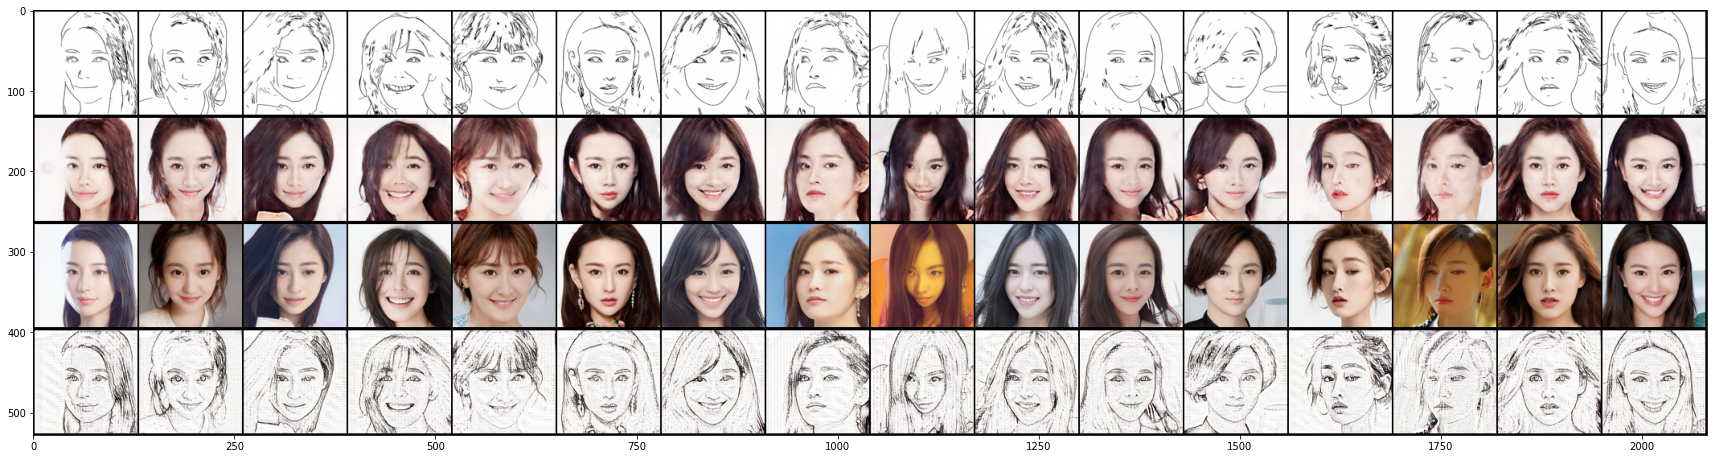

[Epoch 59/60] [Batch 665/704] [D loss: 0.059633] [G loss: 1.525291, adv: 0.813696, cycle: 0.052190, identity: 0.037938] ETA: 0:01:44.319735
[Epoch 59/60] [Batch 666/704] [D loss: 0.054593] [G loss: 1.538291, adv: 0.764347, cycle: 0.058409, identity: 0.037971] ETA: 0:00:22.344265
[Epoch 59/60] [Batch 667/704] [D loss: 0.055594] [G loss: 1.475705, adv: 0.773114, cycle: 0.051199, identity: 0.038119] ETA: 0:00:21.742893
[Epoch 59/60] [Batch 668/704] [D loss: 0.068387] [G loss: 1.647184, adv: 0.797945, cycle: 0.061592, identity: 0.046664] ETA: 0:00:21.130383
[Epoch 59/60] [Batch 669/704] [D loss: 0.073683] [G loss: 1.561921, adv: 0.902047, cycle: 0.048435, identity: 0.035104] ETA: 0:00:20.576848
[Epoch 59/60] [Batch 670/704] [D loss: 0.048744] [G loss: 1.478069, adv: 0.729769, cycle: 0.054116, identity: 0.041428] ETA: 0:00:19.996947
[Epoch 59/60] [Batch 671/704] [D loss: 0.080568] [G loss: 1.505981, adv: 0.828909, cycle: 0.049569, identity: 0.036277] ETA: 0:00:19.386653
[Epoch 59/60] [Batch

In [18]:
train(
    Gen_BA = Gen_BA,
    Gen_AB = Gen_AB,
    Disc_A = Disc_A,
    Disc_B = Disc_B,
    train_dataloader = train_dataloader,
    n_epochs = hp.n_epochs,
    criterion_identity = criterion_identity,
    criterion_cycle = criterion_cycle,
    lambda_cyc = hp.lambda_cyc,
    criterion_GAN = criterion_GAN,
    optimizer_G = optimizer_G,
    fake_A_buffer = fake_A_buffer,
    fake_B_buffer = fake_B_buffer,
    clear_output = clear_output,
    optimizer_Disc_A = optimizer_Disc_A,
    optimizer_Disc_B = optimizer_Disc_B,
    Tensor = Tensor,
    sample_interval = hp.sample_interval,
    lambda_id = hp.lambda_id,
)

I was only able to train the model for 60 epochs given my GPU. Feel free to train the model on your own datasets and for longer. 

If you want to load in my trained parameters you can do that as well with the code below.

In [19]:
# Run this cell to save your parameters 

for model in [{"model":Gen_BA, "name":"Gen_BA"}, {"model": Gen_AB, "name": "Gen_AB"}, {"model": Disc_A, "name": "Disc_A"}, {"model": Disc_B, "name": "Disc_B"}]:
    torch.save(model["model"].state_dict(), "%s.py" %model["name"])

In [20]:
# Run this cell to load in my parameters instead - make sure you upload the 4 model files

for model in [{"model":Gen_BA, "name":"Gen_BA"}, {"model": Gen_AB, "name": "Gen_AB"}, {"model": Disc_A, "name": "Disc_A"}, {"model": Disc_B, "name": "Disc_B"}]:
    state_dict = torch.load("/kaggle/input/models/%s.py" %model["name"])
    model["model"].load_state_dict(state_dict)

# Lets test the model on our sketches!
Finally I get to transorm my own sketches with our GAN. I define the **create_photo** function to generate and display the created photos and call this function inside of the **testing_model** function that first grabs the data and transforms it. 

In [21]:
def create_photo(dataloader):
    Gen_AB.eval()
    Gen_BA.eval()

    for i, batch in enumerate(dataloader):
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        fake_B = Gen_AB(real_A)
        fake_A = Gen_BA(real_B)
        # Arange images along x-axis
        real_A = make_grid(real_A, nrow=16, normalize=True)
        real_B = make_grid(real_B, nrow=16, normalize=True)
        fake_A = make_grid(fake_A, nrow=16, normalize=True)
        fake_B = make_grid(fake_B, nrow=16, normalize=True)
        # Arange images along y-axis
        image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1) 
        path =  '/kaggle/working' + "/%s.png" % (i)   
        save_image(image_grid, path, normalize=False)    
        plot_output(path, 5, 7)
        
def testing_model(data_path, dataloader_name):
    test_paths = glob.glob(data_path)    

    dataloader = DataLoader(
        ImageDataset(mode="test", transforms_=transforms_, test_A=test_paths, test_B=test_paths),
        batch_size=hp.batch_size,
        shuffle=True,
        num_workers=1,
    )

    dataiter = iter(dataloader)
    images = dataiter.next()

    pic_size = 5

    for i in range(len(images["A"])):
      show_img(make_grid([images["A"][i],images["B"][i]]), size=pic_size)
    
    create_photo(dataloader)
    

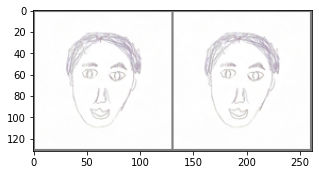

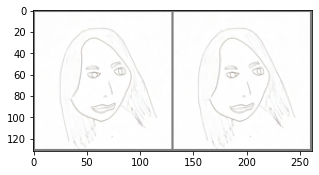

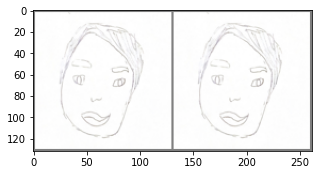

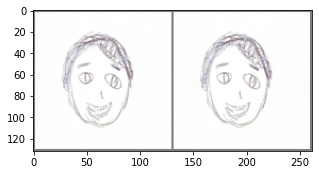

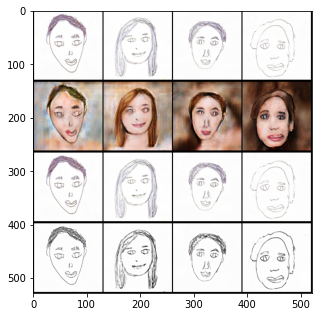

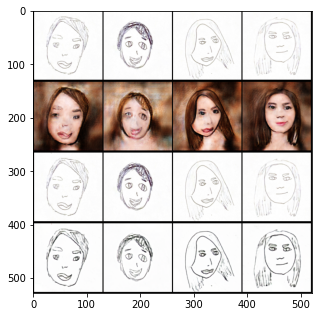

In [22]:
testing_model("../input/my-sketches/*.jpg","my_dataloader")

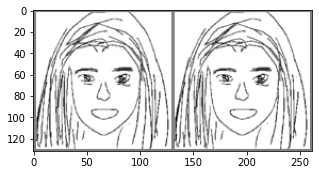

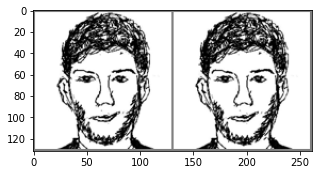

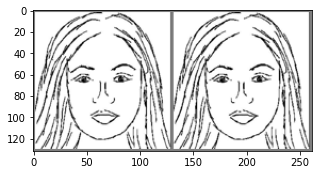

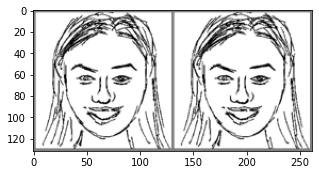

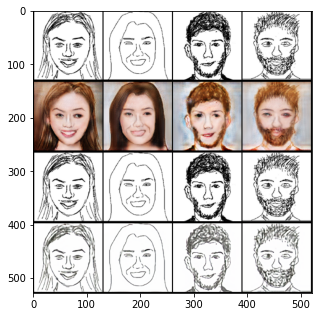

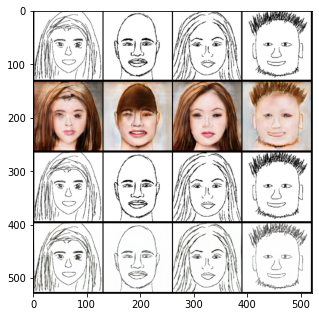

In [23]:
testing_model("../input/google-sketches/*.png", "online_dataloader")

**Congratulations, we just coded a complete end to end sketch based photograph generator 🤯🎉**

The resulted photos generated from my sketches and some sketches I pulled off the web are actually pretty good considering these sketches look *interesting*. This model has tremendous potential in impacting the future of art and entertainment but even much more beyond that. 
1. **Data augmentation**. Sketch-based photograph generators can be used to augment image datasets by generating additional high-resolution photographs from low-resolution sketches or other images. This can be useful for training machine learning models that require large amounts of high-quality data.
2. **Production and Architecture**. Models as such can be used to generate sketch-based realistic images of characters, landscapes, or other elements that are difficult or impossible to capture in real life. They could also be used to generate images of fictional or mythical creatures or objects that do not exist in the real world. Same applies to architecture. In the future, architects could be able to sketch a prototype and automatically generate realistic photographs for rapid feedback and production.
3. **Forensic analysis**. By transforming sketches of crime suspects into photorealistic images, law enforcement agencies can more accurately and promptly identify and locate suspects based on witness descriptions. In addition, GANs can be used to age-progress photos of missing persons, allowing investigators to see what a person may look like after a long period of time has passed. By using GANs to create realistic, updated images of crime suspects and missing persons, law enforcement can have a valuable tool in their efforts to solve crimes and locate missing individuals."

The future of generative AI is just beginning and I can't wait for it to solve problems both big and small.